<a href="https://colab.research.google.com/github/Pbao269/Twiiter-Sentiment-Analysis/blob/main/Twitter_Comment_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Install Kaggle for Dataset
!pip install kaggle

In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 96% 78.0M/80.9M [00:00<00:00, 163MB/s]
100% 80.9M/80.9M [00:00<00:00, 147MB/s]


In [26]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The ds is extracted")

The ds is extracted


Download required tools


In [28]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data Processing

In [64]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


In [65]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [66]:
df.shape

(1600000, 6)

In [67]:
np.sum(df.isnull().any(axis=1))

0

In [68]:
df['target'].unique()


array([0, 4])

In [69]:
df['target'].nunique()

2

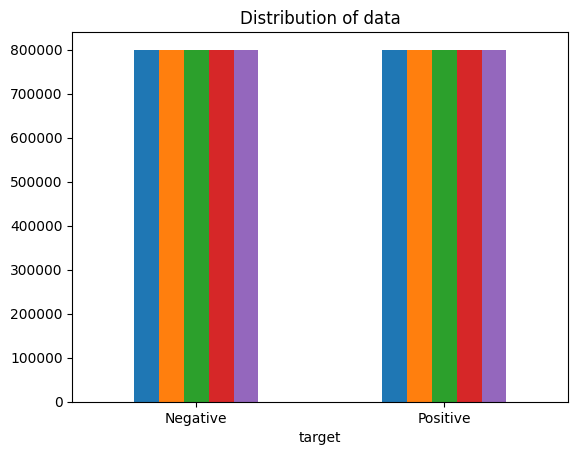

In [70]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

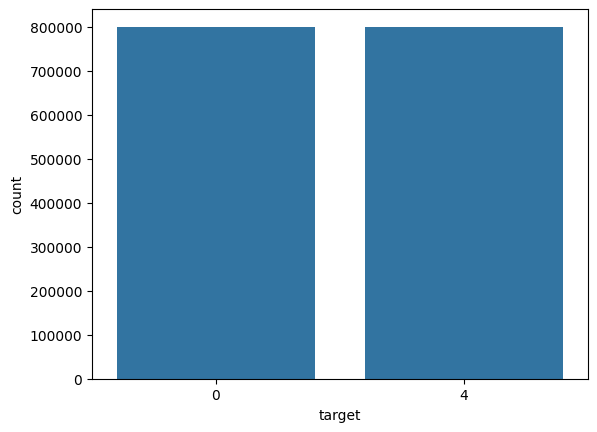

In [71]:
import seaborn as sns
sns.countplot(x='target', data=df)

**Data Processing**

In [72]:
data=df[['text','target']]

In [73]:
data = data.copy()
data['target'] = data['target'].replace(4, 1)


In [74]:
data['target'].unique()

array([0, 1])

Separating Pos and Neg

In [75]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

Extract 1/4 of the dataset to run easier

In [76]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [77]:
dataset = pd.concat([data_pos, data_neg])


In [78]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

,text
19995,"not much time off this weekend, work trip to m..."
19996,one more day of holidays
19997,feeling so down right now .. i hate you damn h...
19998,"geez,i hv to read the whole book of personalit..."
19999,i threw my sign at donnie and he bent over to ...


In [79]:
from nltk.corpus import stopwords

# Get the list of English stopwords
STOPWORDS = set(stopwords.words('english'))

In [80]:
#Remove stopwords from Dataset
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

,text
800000,love @health4uandpets u guys r best!!
800001,im meeting one besties tonight! cant wait!! - ...
800002,"@darealsunisakim thanks twitter add, sunisa! g..."
800003,sick really cheap hurts much eat real food plu...
800004,@lovesbrooklyn2 effect everyone


In [81]:
# Remove punctuation
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

,text
19995,much time weekend work trip malmï¿½ frisat tod...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent get thingee made sad face


In [82]:
# Remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

,text
19995,much time weekend work trip malmï¿½ frisat tod...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent get thingee made sad face


In [83]:
# Remove urls
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

,text
800000,love health4uandpets u guys r best
800001,im meeting one besties tonight cant wait girl...
800002,darealsunisakim thanks twitter add sunisa got ...
800003,sick really cheap hurts much eat real food plu...
800004,lovesbrooklyn2 effect everyone


In [84]:
# Remove numeric chars
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

,text
19995,much time weekend work trip malmï¿½ frisat tod...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent get thingee made sad face


In [85]:
# Get tokenization
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

,text
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


**Apply stemming and lemmatizer**

In [86]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

,text
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


In [88]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


In [89]:
X=data.text
y=data.target

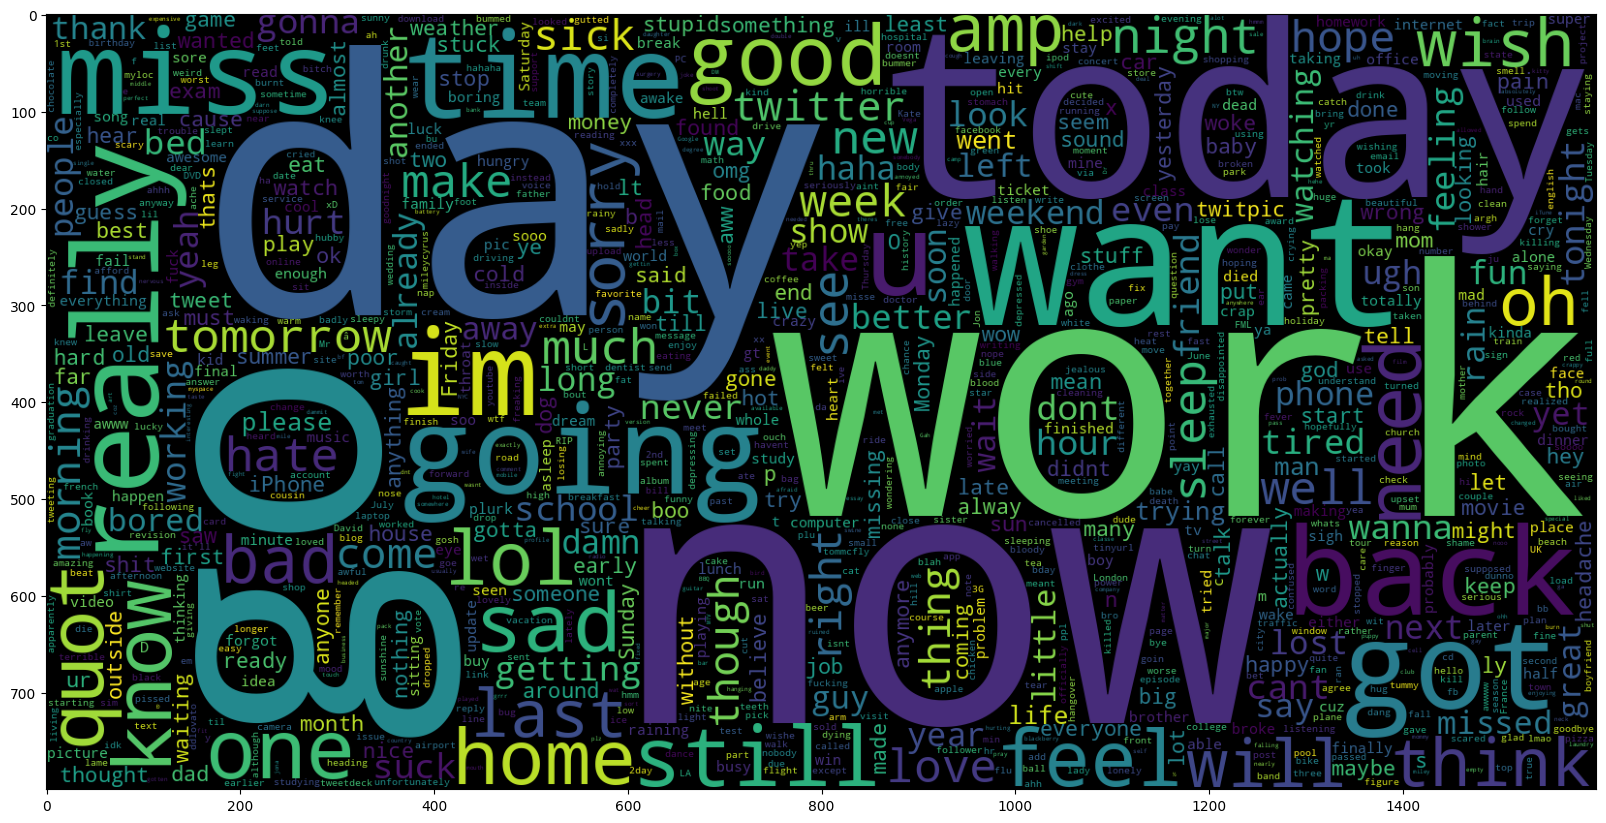

In [90]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

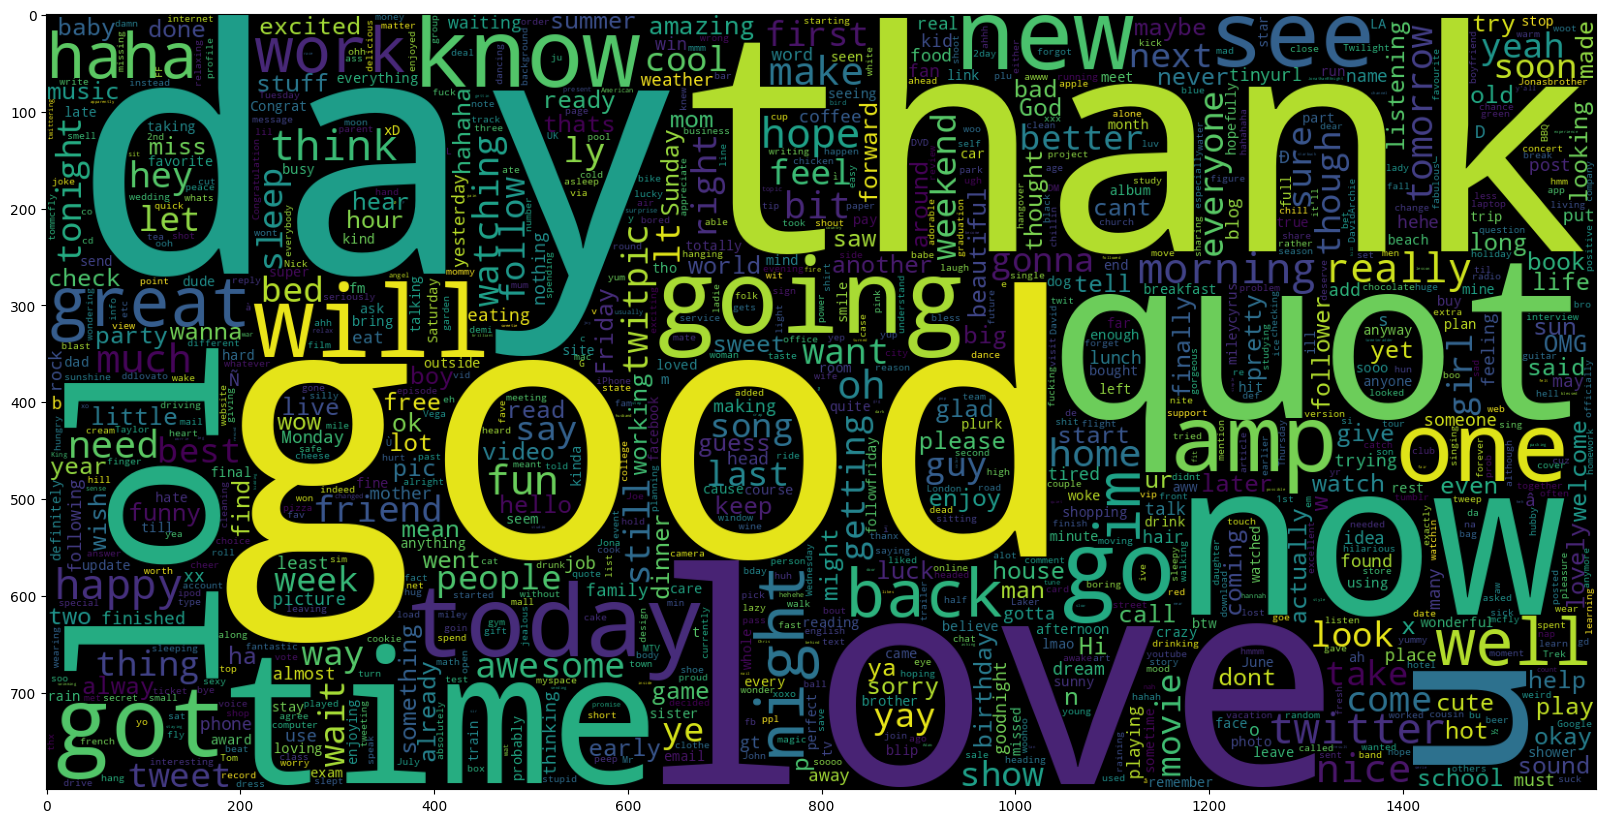

In [91]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [92]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

**Using TF-IDF Vectorizer**

In [94]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))


No. of feature_words:  500000


In [95]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [99]:
import builtins
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion Matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in builtins.zip(group_names, group_percentages)]  # Updated with \n for new lines
    labels = np.asarray(labels).reshape(2, 2)

    # Plot the heatmap
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

In [ ]:
# Naive Bayes

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



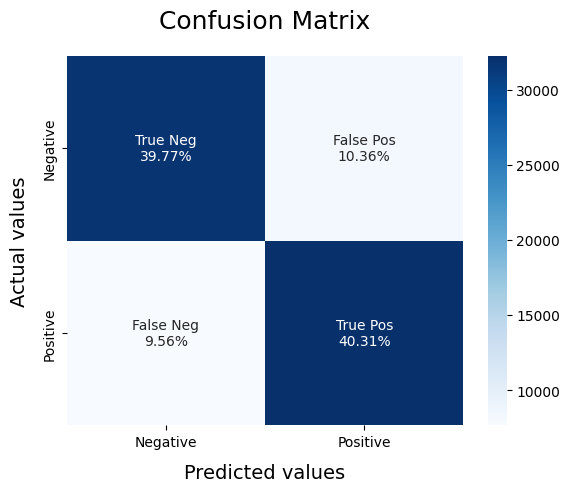

In [100]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

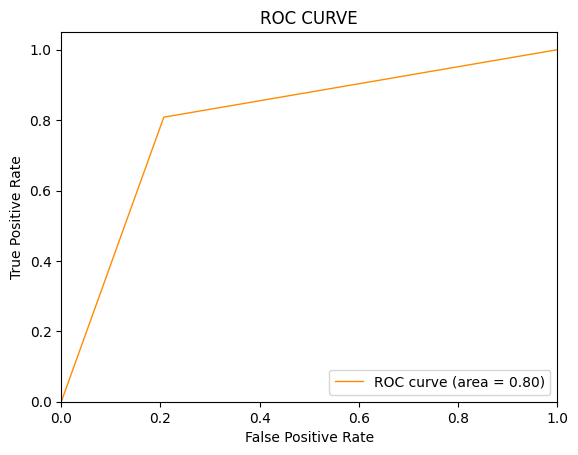

In [101]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



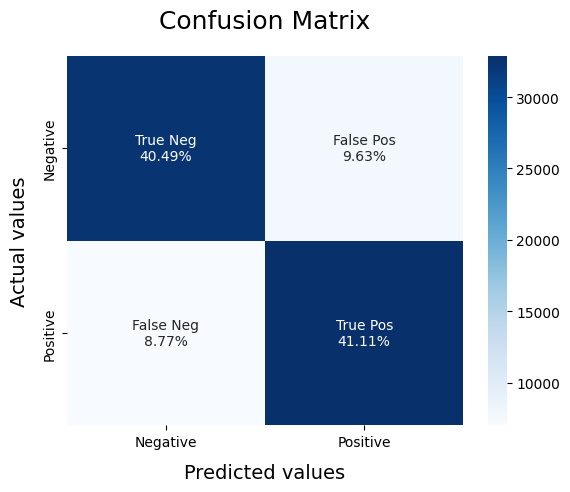

In [102]:
#SVM model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

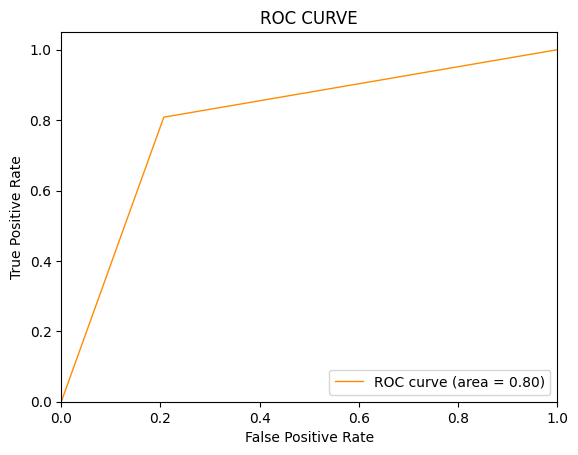

In [103]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     40100
           1       0.81      0.83      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



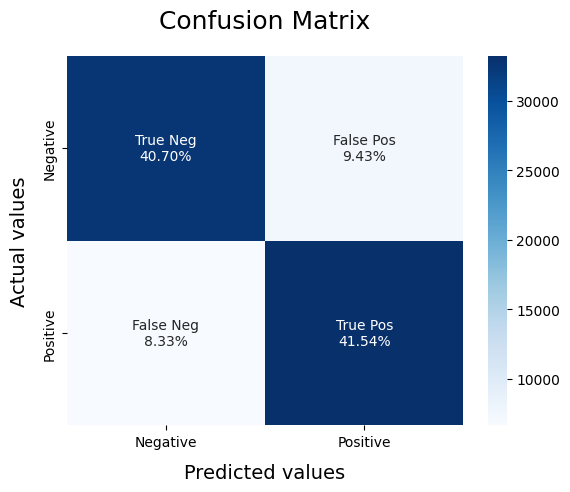

In [105]:
# LR Model
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

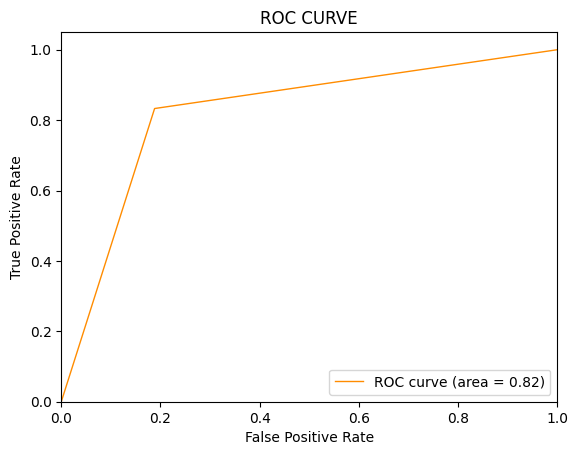

In [106]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
